# INSTACART CLUSTER ANALYSIS

In [62]:
import numpy as np
import pandas as pd
import os
import io
import zipfile
import sys
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
plt.rcParams['font.family'] = 'DejaVu Serif'

**READ THE CSVs AND MAKE THE DATAFRAMES**

In [63]:
aisle_fp = 'aisles.csv'
department_fp = 'departments.csv'
prior_orders_fp = 'order_products__prior.csv'
orders_fp = 'orders.csv'
product_fp = 'products.csv'

# Read CSVs into DataFrames
aisles = pd.read_csv(aisle_fp)
departments = pd.read_csv(department_fp)
orders_prior = pd.read_csv(prior_orders_fp)
orders = pd.read_csv(orders_fp)
products = pd.read_csv(product_fp)

In [64]:
print(aisles.head())
print(departments.head())
print(orders_prior.head())
print(orders.head())
print(products.head())

   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior        

**DATA CLEANING**

We need to figure out what DataFrames have null values and make all numerics a consistent type (int).

In [65]:
print("Products:")
print(products.isna().sum())
print()

print("Aisles:")
print(aisles.isna().sum())
print()

print("Departments:")
print(departments.isna().sum())
print()

print("Orders:")
print(orders.isna().sum())
print()

print("Prior Orders:")
print(orders_prior.isna().sum())
print()

Products:
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

Aisles:
aisle_id    0
aisle       0
dtype: int64

Departments:
department_id    0
department       0
dtype: int64

Orders:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Prior Orders:
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64



In [66]:
# days_since_prior_order is a float
orders.dtypes


order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

**DATA CLEANING CODE**

In [67]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].apply(lambda x: 0 if math.isnan( x ) else x ) # Orders has null values in 'days_since_prior_order'
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int) # Convert days_since_prior_order from float to int

**DATAFRAME OF ALL THE TABLES**

In [68]:
order_products = orders_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on ='order_id', how='left')
order_products = order_products.dropna()

In [69]:
order_products

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21


# CLUSTER ANALYSIS 1: Wealth and Interests of Consumer

To better analyze user purchasing behavior, we will create new features: total number of products per user and how many unique aisles the user buys from. The dataset doesn't contain monetary value for purchases, so we are assumming # of products is correlated with wealth.


**FEATURE ENGINEERING**

Adding new columns:

* Total number of products per user
* How many unique aisles the user buys from



In [70]:
orders_df1 = order_products.copy()

# Total number of products per user
user_product_counts = orders_df1.groupby('user_id')['product_id'].count().reset_index() # Group by user_id and calculate the total number of products purchased
user_product_counts.rename(columns={'product_id': 'total_products'}, inplace=True)  # rename column
orders_df1 = orders_df1.merge(user_product_counts, on='user_id', how='left') # Merge the total product counts back to the order_products DataFrame

# How many unique aisles the user buys from
user_unique_aisle_counts = orders_df1.groupby('user_id')['aisle_id'].nunique().reset_index()
user_unique_aisle_counts.rename(columns={'aisle_id': 'distinct_aisles'}, inplace=True)
orders_df1 = orders_df1.merge(user_unique_aisle_counts, on='user_id', how='left')

In [71]:
orders_df1

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_products,distinct_aisles
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8,90,27
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8,90,27
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8,90,27
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8,90,27
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8,90,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,prior,24,2,6,21,250,45
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,prior,24,2,6,21,250,45
32434486,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,prior,24,2,6,21,250,45
32434487,3421083,24852,9,1,Banana,24,4,fresh fruits,produce,25247,prior,24,2,6,21,250,45


**MERGING THE 2 FEATURE DERIVED ABOVE**

In [72]:
df_feat = pd.merge(user_product_counts, user_unique_aisle_counts, how='inner', on='user_id')
df_feat

,user_id,total_products,distinct_aisles
0,1,59,12
1,2,195,33
2,3,88,16
3,4,18,14
4,5,37,16
...,...,...,...
206204,206205,32,17
206205,206206,285,50
206206,206207,223,46
206207,206208,677,63


**FEATURE ENGINEERING STATS**

In [73]:
min_df = pd.DataFrame( df_feat.apply(lambda x: min(x), axis=0) ).T

max_df = pd.DataFrame( df_feat.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( df_feat.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( df_feat.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( df_feat.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( df_feat.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( df_feat.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( df_feat.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,user_id,1.0,206209.0,206208.0,103105.000000,103105.0,59527.410829,0.000000,-1.200000
1,total_products,3.0,3725.0,3722.0,157.289396,83.0,204.207738,3.179127,15.351197
2,distinct_aisles,1.0,102.0,101.0,27.783700,25.0,16.111491,0.713979,0.102604


**DISTRIBUTION OF FEATURES ADDED**

<Axes: title={'center': 'Distribution of distinct aisles bought from per user'}, xlabel='distinct_aisles', ylabel='Count'>

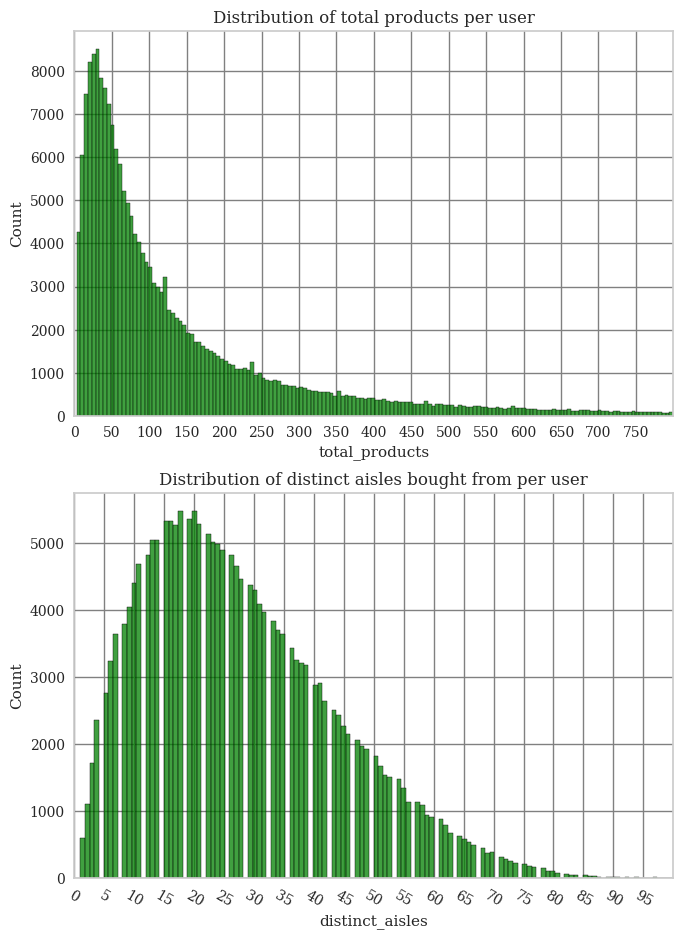

In [74]:
plt.figure(figsize=(17,11))
plt.subplot(2,2,1)
plt.title('Distribution of total products per user')
plt.xticks( np.arange(0, 800, 50), rotation=0 )
plt.xlim((0,800))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df_feat['total_products'], color='green')


plt.subplot(2,2,3)
plt.title('Distribution of distinct aisles bought from per user')
plt.xticks( np.arange(0, 100, 5), rotation=-30 )
plt.xlim((0,100))
plt.grid(color='gray', linestyle='-', linewidth=1)
sns.histplot(df_feat['distinct_aisles'], color='green')

**FEATURE SCALING**

Feature scaling is often recommended when using distance-based clustering algorithms like K-means. Scaling ensures that all features contribute equally to the distance computations, preventing features with larger scales from dominating the clustering process.

MixMax scaling scales the feature into a specific range. Robust scaling is better for data with outliers.

In [75]:
df_feat2 = df_feat.copy()

<Axes: xlabel='total_products'>

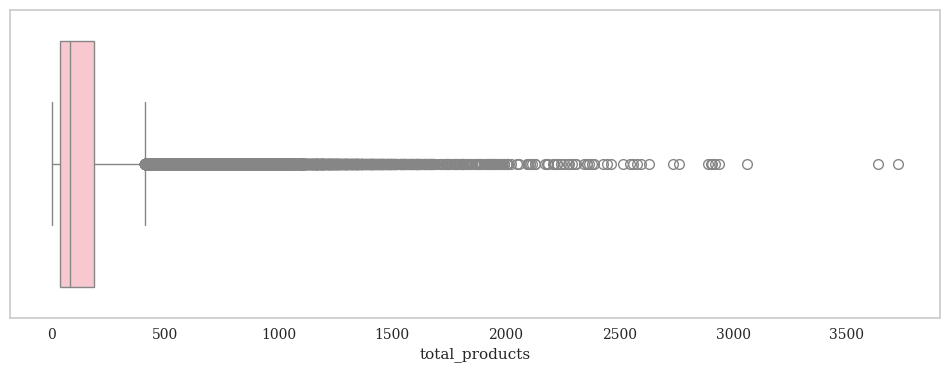

In [76]:
plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['total_products'], orient='h', color='pink')

There are some outliers, so we will use Robust scaling

<Axes: xlabel='distinct_aisles'>

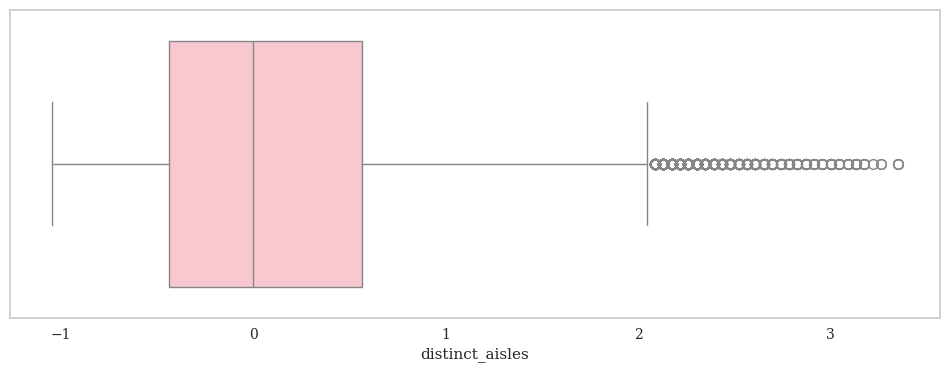

In [77]:
rs = RobustScaler()
df_feat2['distinct_aisles'] = rs.fit_transform( df_feat2[['distinct_aisles']].values )

plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['distinct_aisles'], orient='h', color='pink')

There are some outliers, so we will use Robust scaling

<Axes: xlabel='total_products'>

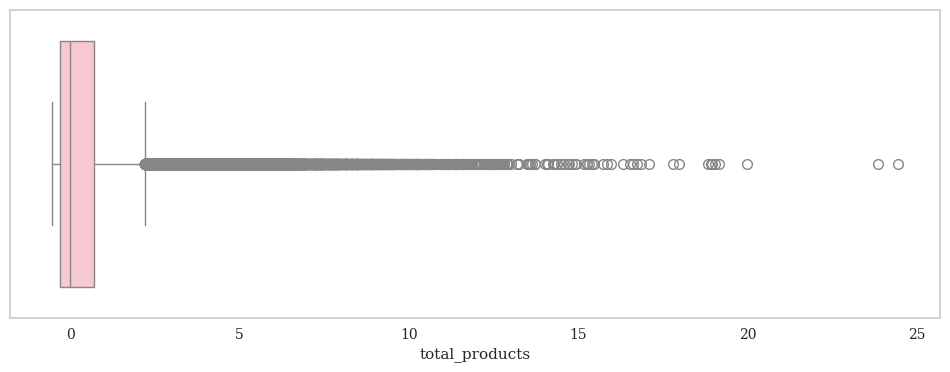

In [78]:
rs = RobustScaler()
df_feat2['total_products'] = rs.fit_transform( df_feat2[['total_products']].values )

plt.figure(figsize=(12,4))
plt.grid(False)

sns.boxplot( data=df_feat2['total_products'], orient='h', color='pink')

Applying logarithm transformation.

In [79]:
small_constant = 1e-9
df_feat2['total_products'] = np.where(df_feat2['total_products'] <= 0, small_constant, df_feat2['total_products'])
df_feat2['distinct_aisles'] = np.where(df_feat2['distinct_aisles'] <= 0, small_constant, df_feat2['distinct_aisles'])

df_feat2['total_products'] = np.log1p( df_feat2['total_products'] )
df_feat2['distinct_aisles'] = np.log1p( df_feat2['distinct_aisles'] )

**Using cumulative variance to determine how many components to use for PCA**

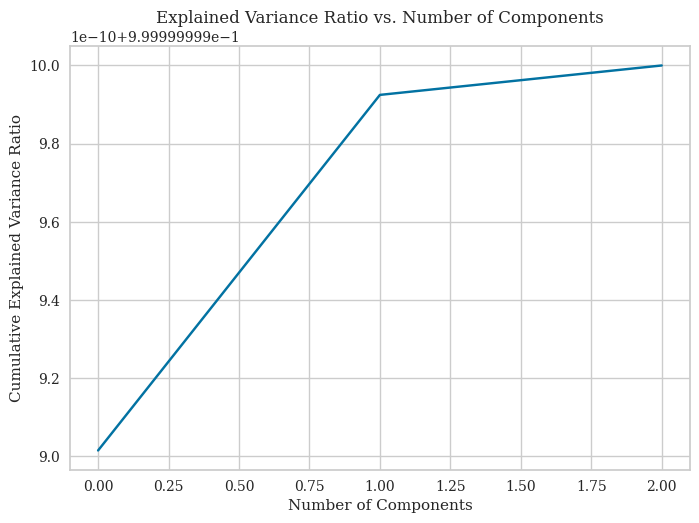

In [80]:
from sklearn.decomposition import PCA
pca2 = PCA()


pca2.fit(df_feat2)


plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

1 component captures over 98% of the data.  The 'elbow point' is when rate of increase in explained variance starts to slow down significantly at 1 component. This point often represents the optimal number of PCs to retain.

**PCA ANALYSIS**

In [81]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=1)
pca_df2 = pca2.fit_transform(df_feat2[['total_products', 'distinct_aisles']])
pca_df2 = pd.DataFrame(pca_df2)
display(pca_df2)

,0
0,-0.405222
1,0.229531
2,-0.376610
3,-0.405222
4,-0.405222
...,...
206204,-0.405222
206205,0.704330
206206,0.492468
206207,1.473883


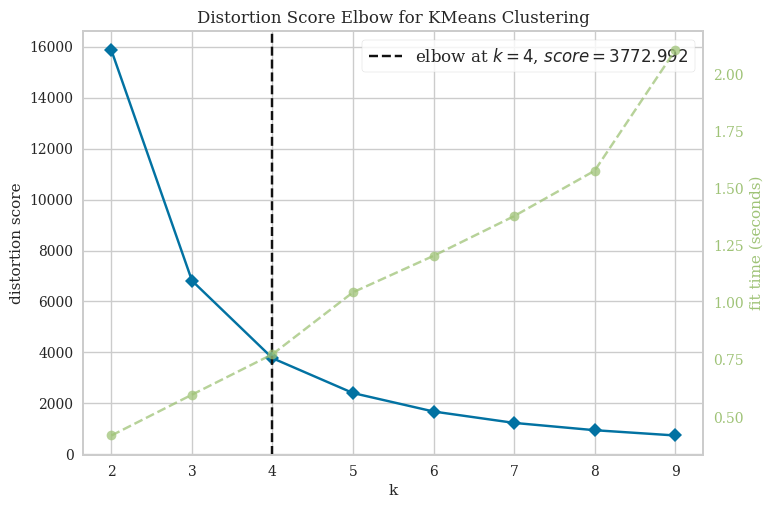

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [82]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(n_init=10)
elbow_chart2 = KElbowVisualizer(kmeans, k=(2,10))
elbow_chart2.fit(pca_df2)
elbow_chart2.show()

The "elbow point" in the plot represents the optimal number of clusters -> 4

**K-MEANS CLUSTERING**

In [83]:
kmeans2 = KMeans(n_init=10, n_clusters=4, random_state=42)
cluster_labels2 = kmeans2.fit_predict(pca_df2)
df_feat['cluster'] = cluster_labels2

In [84]:
num_clusters2 = df_feat['cluster'].nunique()
cluster_results2 = []

# Iterate through each cluster
for cluster_num in range(num_clusters2):
    cluster_data = df_feat[df_feat['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results2.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results2:
    cluster_name, cluster_mean = result
    print(f"Cluster {cluster_name}")
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster Cluster 0


,Feature,Mean
0,user_id,102749.691392
1,total_products,327.574030
2,distinct_aisles,46.223545




Cluster Cluster 1


,Feature,Mean
0,user_id,103133.573506
1,total_products,51.881096
2,distinct_aisles,17.956177




Cluster Cluster 2


,Feature,Mean
0,user_id,102644.462114
1,total_products,747.717870
2,distinct_aisles,59.325112




Cluster Cluster 3


,Feature,Mean
0,user_id,103428.853871
1,total_products,164.823347
2,distinct_aisles,35.138768


In [85]:
cluster_user_ids2 = df_feat.groupby('cluster')['user_id'].unique()

# Print user IDs for each cluster
for cluster_label, user_ids in cluster_user_ids2.items():
    print(f"Cluster {cluster_label} User IDs: {user_ids}")

Cluster 0 User IDs: [    14     17     19 ... 206201 206206 206207]
Cluster 1 User IDs: [     1      3      4 ... 206198 206204 206205]
Cluster 2 User IDs: [    27     54     63 ... 206165 206174 206208]
Cluster 3 User IDs: [     2      7     10 ... 206202 206203 206209]


# CLUSTER ANALYSIS 2: Aisles Purchased From

We will cluster based on the aisles that customers buy products from.



In [86]:
cross_order_product = pd.crosstab(order_products.user_id, order_products.aisle)
cross_order_product.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


Normalize the data

In [87]:
normalize_df = cross_order_product.div(cross_order_product.sum(axis=1), axis=0)
normalize_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


**Using cumulative variance to determine how many components to use for PCA**


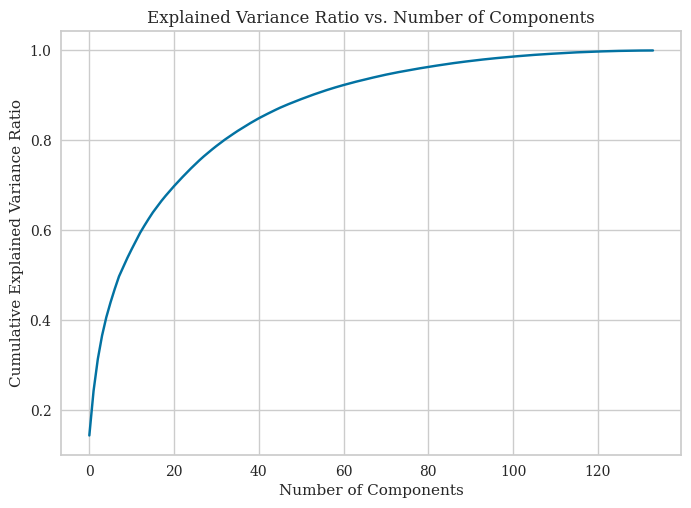

In [88]:
normalized2 = normalize_df.copy()
# Fit PCA with a range of components
pca = PCA()
pca.fit(normalized2)

# Plot explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

**PCA ANALYSIS**

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components=80)
pca_df = pca.fit_transform(normalized2)
pca_df = pd.DataFrame(pca_df)
display(pca_df)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.113443,0.039084,-0.042863,0.018865,-0.088341,-0.104549,-0.116443,0.083694,-0.062523,-0.026177,...,-0.000547,-0.013340,-0.005467,0.000140,-0.001672,0.000078,0.001164,-0.000881,0.001637,0.000812
1,-0.036988,0.108884,-0.066406,-0.123271,0.098849,-0.033960,-0.054736,-0.053366,-0.020370,-0.008092,...,-0.004118,-0.008169,-0.000805,-0.000032,-0.002577,0.000297,-0.004303,0.003523,0.001397,-0.000550
2,0.064282,0.103962,0.000710,-0.012221,-0.046984,0.112238,-0.029812,0.007860,0.012277,0.001852,...,-0.004475,-0.001040,0.001211,-0.003734,0.000744,-0.000484,-0.004148,-0.000004,-0.001904,-0.000168
3,-0.093210,0.054093,0.001867,-0.003974,-0.071356,-0.019278,-0.025115,-0.038234,0.006492,-0.000623,...,-0.001215,0.019811,-0.022422,-0.029144,0.021540,0.003425,-0.025041,0.003820,0.017509,0.000552
4,0.094629,-0.037051,-0.024952,-0.021575,0.055369,0.107649,-0.008034,0.103931,0.051732,-0.025799,...,0.004577,-0.000977,0.004384,-0.004428,-0.000656,-0.005398,-0.001095,0.000183,-0.000112,0.001795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,-0.026367,0.027732,-0.067101,-0.033285,0.118231,-0.058467,0.051550,0.017584,-0.026899,-0.023101,...,-0.004337,0.002049,-0.002840,-0.001119,-0.005396,-0.002595,-0.001321,-0.000322,0.003674,0.000503
206205,-0.089921,-0.045631,-0.048018,0.012692,-0.060298,-0.002377,-0.013544,-0.044109,0.157265,-0.011178,...,0.001140,0.003587,-0.006837,-0.009183,0.010637,-0.000241,-0.005605,-0.001432,-0.000750,-0.003161
206206,-0.024815,-0.013314,-0.003664,-0.031273,0.032279,0.021374,0.037840,0.032540,-0.020156,-0.009905,...,0.014812,-0.005151,0.011636,-0.004554,-0.002635,-0.000073,-0.004128,-0.000241,0.006427,0.001000
206207,-0.009370,-0.003186,-0.045535,-0.012414,0.013405,0.056799,0.008895,0.027282,-0.016115,0.013962,...,0.000814,0.000515,0.000763,-0.002662,0.000179,-0.003602,-0.002977,-0.000400,0.004600,0.000112


**ELBOW METHOD TO FIND OPTIMAL NUMBER OF CLUSTERS**

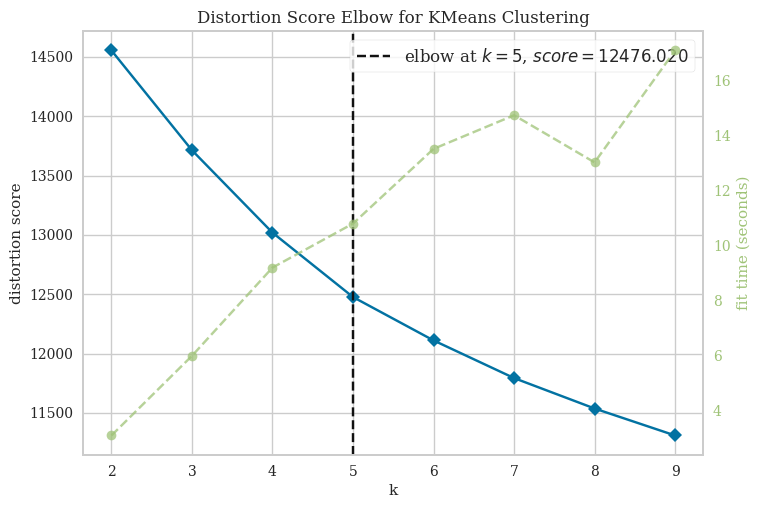

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(n_init=10)
elbow_chart = KElbowVisualizer(kmeans, k=(2,10))
elbow_chart.fit(pca_df)
elbow_chart.show()

The "elbow point" in the plot represents the optimal number of clusters -> 5

**K-MEANS CLUSTERING**

In [91]:
cross_op_product = cross_order_product.copy()

cross_op2 = cross_order_product.drop('fresh fruits', axis=1)
cross_op2 = cross_op2.drop('fresh vegetables', axis=1)
cross_op2 = cross_op2.drop('yogurt', axis=1)
cross_op2 = cross_op2.drop('packaged vegetables fruits', axis=1)
cross_op2 = cross_op2.drop('milk', axis=1)
cross_op2.reset_index(inplace=True)
cross_op2

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,0,3,0,0,0,0,2,0,0,...,0,3,1,1,0,0,0,0,2,0
2,3,0,0,0,0,0,0,0,0,0,...,0,4,1,0,0,0,0,0,2,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206205,206206,0,4,0,0,0,0,4,1,0,...,0,1,0,0,0,0,1,0,1,0
206206,206207,0,0,0,0,1,0,0,0,0,...,0,3,4,0,2,1,0,0,11,0
206207,206208,0,3,0,0,3,0,4,0,0,...,0,5,0,0,7,0,0,0,0,0


## We will cluster on aisles twice: with and without including very common produce items

Some aisles dominate the dataset, so to find more interesting patterns, we have dropped 'fresh fruits', 'fresh vegetables', 'yogurt', 'packaged vegetables fruits', and 'milk'.

### CLUSTERING WITHOUT PRODUCE

In [92]:
kmeans = KMeans(n_init=10, n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cross_op2['cluster'] = cluster_labels

In [93]:
num_clusters = cross_op2['cluster'].nunique()
cluster_results = []

# Iterate through each cluster
for cluster_num in range(num_clusters):
    cluster_data = cross_op2[cross_op2['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results:
    cluster_name, cluster_mean = result
    print(cluster_name)
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster 0


,aisle,Mean
0,user_id,102736.152884
1,packaged cheese,5.002823
2,fresh herbs,4.160093
3,soy lactosefree,3.709118
4,frozen produce,3.295664
5,water seltzer sparkling water,3.076711
6,eggs,2.779915
7,bread,2.728552
8,chips pretzels,2.567003
9,canned jarred vegetables,2.476737




Cluster 1


,aisle,Mean
0,user_id,103240.756347
1,packaged cheese,4.919112
2,chips pretzels,4.480273
3,water seltzer sparkling water,4.100655
4,refrigerated,3.254760
5,ice cream ice,3.097411
6,bread,3.034875
7,soy lactosefree,2.797750
8,frozen meals,2.746746
9,crackers,2.685605




Cluster 2


,aisle,Mean
0,user_id,103925.310115
1,packaged produce,18.370198
2,water seltzer sparkling water,1.722635
3,packaged cheese,1.558635
4,chips pretzels,1.145358
5,frozen produce,1.139942
6,nuts seeds dried fruit,1.032876
7,oils vinegars,0.933493
8,bread,0.888273
9,cereal,0.871142




Cluster 3


,aisle,Mean
0,user_id,103402.412731
1,water seltzer sparkling water,20.916558
2,soft drinks,2.806235
3,energy granola bars,1.526414
4,chips pretzels,1.319582
5,tea,1.319022
6,soy lactosefree,1.070375
7,candy chocolate,1.046108
8,cream,1.042748
9,coffee,0.988240




Cluster 4


,aisle,Mean
0,user_id,103078.334064
1,packaged cheese,5.160237
2,soy lactosefree,3.788559
3,water seltzer sparkling water,3.623132
4,bread,3.215588
5,chips pretzels,3.135065
6,frozen produce,2.990140
7,refrigerated,2.938441
8,energy granola bars,2.528002
9,eggs,2.476302


### CLUSTERING WITH PRODUCE

In [94]:
cross_op_product['cluster'] = cluster_labels

In [95]:
num_clusters = cross_op_product['cluster'].nunique()
cluster_results = []

# Iterate through each cluster
for cluster_num in range(num_clusters):
    cluster_data = cross_op_product[cross_op_product['cluster'] == cluster_num]
    cluster_mean = cluster_data.drop('cluster', axis=1).mean().sort_values(ascending=False)[0:20]
    cluster_results.append((f"Cluster {cluster_num}", cluster_mean))

# Display all results in separate tables
for result in cluster_results:
    cluster_name, cluster_mean = result
    print(cluster_name)
    display(pd.DataFrame(cluster_mean, columns=['Mean']).reset_index().rename(columns={'index': 'Feature'}))
    print("\n")

Cluster 0


,aisle,Mean
0,fresh vegetables,37.061988
1,fresh fruits,21.698835
2,packaged vegetables fruits,12.011578
3,yogurt,6.140425
4,packaged cheese,5.002823
5,fresh herbs,4.160093
6,milk,3.989789
7,soy lactosefree,3.709118
8,frozen produce,3.295664
9,water seltzer sparkling water,3.076711




Cluster 1


,aisle,Mean
0,fresh fruits,9.724877
1,fresh vegetables,7.552379
2,yogurt,7.197813
3,packaged vegetables fruits,5.980546
4,packaged cheese,4.919112
5,chips pretzels,4.480273
6,milk,4.246796
7,water seltzer sparkling water,4.100655
8,refrigerated,3.254760
9,ice cream ice,3.097411




Cluster 2


,aisle,Mean
0,packaged produce,18.370198
1,fresh fruits,10.875425
2,packaged vegetables fruits,4.227107
3,fresh vegetables,3.107318
4,water seltzer sparkling water,1.722635
5,milk,1.618340
6,packaged cheese,1.558635
7,chips pretzels,1.145358
8,frozen produce,1.139942
9,nuts seeds dried fruit,1.032876




Cluster 3


,aisle,Mean
0,water seltzer sparkling water,20.916558
1,fresh fruits,3.288594
2,soft drinks,2.806235
3,yogurt,2.221766
4,energy granola bars,1.526414
5,chips pretzels,1.319582
6,tea,1.319022
7,milk,1.309128
8,packaged vegetables fruits,1.214486
9,soy lactosefree,1.070375




Cluster 4


,aisle,Mean
0,fresh fruits,35.708558
1,fresh vegetables,15.115998
2,packaged vegetables fruits,12.137856
3,yogurt,9.936563
4,milk,5.973263
5,packaged cheese,5.160237
6,soy lactosefree,3.788559
7,water seltzer sparkling water,3.623132
8,bread,3.215588
9,chips pretzels,3.135065


**SUMMARY DATA OF ENTIRE DATASET**

In [96]:
num_data = order_products.select_dtypes( include=['int64'] )
cat_data = order_products.select_dtypes( exclude=['int64'] )


min_df = pd.DataFrame( num_data.apply(lambda x: min(x), axis=0) ).T
min_df['days_since_prior_order'] = min( num_data[ num_data['days_since_prior_order'] != -1 ]['days_since_prior_order'] )

max_df = pd.DataFrame( num_data.apply(lambda x : max(x), axis=0) ).T

range_df = pd.DataFrame( num_data.apply(lambda x : max(x) - min(x), axis=0 )).T

mean_df = pd.DataFrame( num_data.apply(lambda x : np.mean(x), axis=0 )).T

median_df = pd.DataFrame( num_data.apply(lambda x : np.median(x), axis=0 )).T

std_df = pd.DataFrame( num_data.apply(lambda x : np.std(x), axis=0 )).T

skew_df = pd.DataFrame( num_data.apply(lambda x : x.skew(), axis=0 )).T

kurtosis_df = pd.DataFrame( num_data.apply(lambda x : x.kurtosis(), axis=0 )).T


attributes_table = pd.concat([min_df, max_df, range_df, mean_df, median_df, std_df, skew_df, kurtosis_df]).T.reset_index()
attributes_table.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
attributes_table

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,order_id,2.0,3421083.0,3421081.0,1.710749e+06,1711048.0,987300.681233,-0.000490,-1.199128
1,product_id,1.0,49688.0,49687.0,2.557634e+04,25256.0,14096.688873,-0.021131,-1.140816
2,add_to_cart_order,1.0,145.0,144.0,8.351076e+00,6.0,7.126671,1.818071,5.643873
3,reordered,0.0,1.0,1.0,5.896975e-01,1.0,0.491889,-0.364706,-1.866989
4,aisle_id,1.0,134.0,133.0,7.121430e+01,83.0,38.203023,-0.167779,-1.324764
5,department_id,1.0,21.0,20.0,9.921906e+00,9.0,6.281155,0.150884,-1.560794
6,user_id,1.0,206209.0,206208.0,1.029372e+05,102611.0,59466.477351,0.006612,-1.200923
7,order_number,1.0,99.0,98.0,1.714205e+01,11.0,17.535040,1.756896,3.256605
8,order_dow,0.0,6.0,6.0,2.738818e+00,3.0,2.090049,0.180193,-1.333989
9,order_hour_of_day,0.0,23.0,23.0,1.342498e+01,13.0,4.246365,-0.044083,-0.011658


## Comparing Cluster Analysis 1 (customer wealth and interests) and Cluster Analysis 2 (aisles)

### WITHOUT PRODUCE

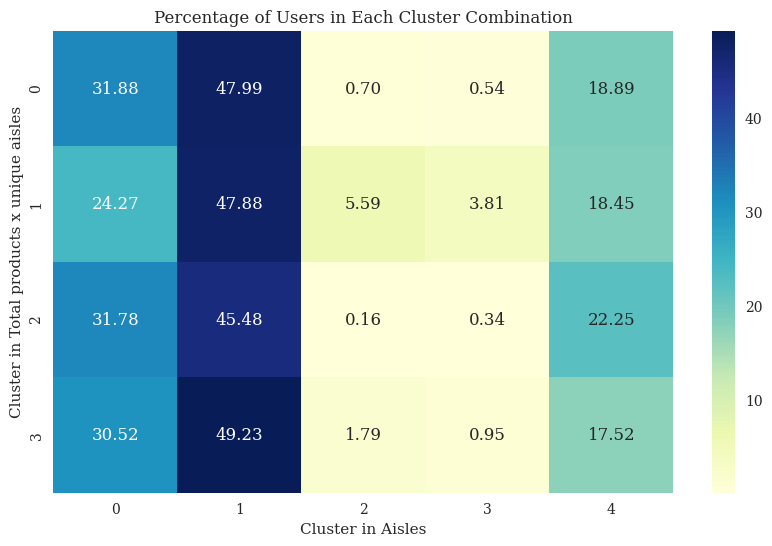

In [97]:
cross_op3 = cross_op2.copy()
cross_op3.rename(columns={'cluster': 'cluster_cross_op'}, inplace=True)

df_feat_final = df_feat.copy()
combined_df = pd.merge(df_feat_final, cross_op3, on='user_id', how='inner')

# Group by cluster labels from both DataFrames
grouped = combined_df.groupby(['cluster', 'cluster_cross_op']).size().reset_index(name='count')

# Calculate the total count of users in each cluster from df_feat2
total_users_df_feat2 = df_feat_final.groupby('cluster').size()

# Calculate the percentage of users in each combination relative to the total number of users in the corresponding cluster from df_feat2
grouped['percentage'] = grouped.apply(lambda row: (row['count'] / total_users_df_feat2[row['cluster']]) * 100, axis=1)


heatmap_data = grouped.pivot(index='cluster', columns='cluster_cross_op', values='percentage')
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Percentage of Users in Each Cluster Combination')
plt.xlabel('Cluster in Aisles')
plt.ylabel('Cluster in Total products x unique aisles')
plt.show()

### CLUSTERING WITH PRODUCE

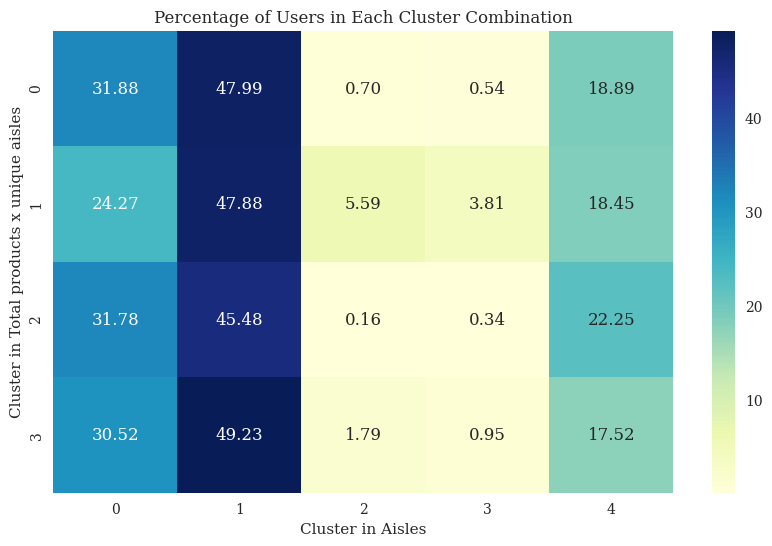

In [98]:
cross_op_product2 = cross_op_product.copy()
cross_op_product2.rename(columns={'cluster': 'cluster_cross_op'}, inplace=True)

df_feat_final2 = df_feat.copy()
combined_df2 = pd.merge(df_feat_final2, cross_op_product2, on='user_id', how='inner')

# Group by cluster labels from both DataFrames
grouped2 = combined_df2.groupby(['cluster', 'cluster_cross_op']).size().reset_index(name='count')

# Calculate the total count of users in each cluster from df_feat2
total_users_df_feat2 = df_feat_final2.groupby('cluster').size()

# Calculate the percentage of users in each combination relative to the total number of users in the corresponding cluster from df_feat2
grouped2['percentage'] = grouped2.apply(lambda row: (row['count'] / total_users_df_feat2[row['cluster']]) * 100, axis=1)


heatmap_data2 = grouped2.pivot(index='cluster', columns='cluster_cross_op', values='percentage')
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data2, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Percentage of Users in Each Cluster Combination')
plt.xlabel('Cluster in Aisles')
plt.ylabel('Cluster in Total products x unique aisles')
plt.show()